In [46]:
# https://chatgpt.com/c/6751f5eb-89a8-8011-923e-d7545dd9e692

In [47]:
# %pip install pymongo dask

In [48]:
# %pip install pymongo tqdm psutil


In [5]:
import os
import json
import pymongo
from pymongo import MongoClient
from tqdm import tqdm
from pathlib import Path

# MongoDB connection setup
MONGO_URI = "mongodb://localhost:27017"  # Replace with your MongoDB URI
DB_NAME = "drug_data"
COLLECTION_NAME = "reports"

client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLLECTION_NAME]

# Directory containing the JSON files
DATA_DIR = "data"

# Record progress in a log file
PROGRESS_FILE = "progress_log.json"

def load_progress():
    """Load progress from log file."""
    if os.path.exists(PROGRESS_FILE):
        with open(PROGRESS_FILE, "r") as f:
            return json.load(f)
    return {}

def save_progress(progress):
    """Save progress to log file."""
    with open(PROGRESS_FILE, "w") as f:
        json.dump(progress, f)

def get_total_size_and_files(data_dir):
    """Get total size and list of all JSON files."""
    total_size = 0
    all_files = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".json"):
                full_path = os.path.join(root, file)
                total_size += os.path.getsize(full_path)
                all_files.append(full_path)
    return total_size, all_files

def process_file(file_path, collection):
    """Process a single JSON file and insert its content into MongoDB."""
    with open(file_path, "r") as f:
        data = json.load(f)
        if isinstance(data, list):  # If JSON contains a list of records
            collection.insert_many(data)
        elif isinstance(data, dict) and "results" in data:  # If data has 'results' key
            collection.insert_many(data["results"])
        else:
            collection.insert_one(data)  # If a single record
    return os.path.getsize(file_path)

def main():
    # Load progress
    progress = load_progress()

    # Get total size and list of files
    total_size, all_files = get_total_size_and_files(DATA_DIR)
    processed_size = progress.get("processed_size", 0)
    processed_files = set(progress.get("processed_files", []))

    print(f"Total files: {len(all_files)}, Total size: {total_size / (1024 ** 2):.2f} MB")
    
    # Initialize progress bar
    with tqdm(total=total_size, initial=processed_size, unit="B", unit_scale=True, desc="Processing JSONs") as pbar:
        for file_path in all_files:
            file_name = Path(file_path).name

            if file_name in processed_files:
                continue  # Skip already processed files

            try:
                file_size = process_file(file_path, collection)
                processed_size += file_size
                processed_files.add(file_name)

                # Update progress
                progress["processed_size"] = processed_size
                progress["processed_files"] = list(processed_files)
                save_progress(progress)

                pbar.update(file_size)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    print("Processing complete!")

if __name__ == "__main__":
    main()


Total files: 5, Total size: 1243.21 MB


Processing JSONs: 100%|████████████████████| 1.30G/1.30G [00:15<00:00, 85.7MB/s]

Processing complete!


In [5]:
# %pip install ipywidgets --upgrade


In [11]:
#a. Count total documents in the collection:

In [7]:
db.reports.count_documents({})


54041

In [10]:
# b. View a sample document:

In [12]:
db.reports.find_one()


{'_id': ObjectId('6755de47ae94c27a1e194618'),
 'safetyreportid': '4446129-3',
 'transmissiondateformat': '102',
 'transmissiondate': '20050211',
 'serious': '1',
 'seriousnessother': '1',
 'receivedateformat': '102',
 'receivedate': '20040907',
 'receiptdateformat': '102',
 'receiptdate': '20040825',
 'fulfillexpeditecriteria': '1',
 'companynumb': 'AU-BRISTOL-MYERS SQUIBB COMPANY-12685384',
 'primarysource': {'qualification': '3'},
 'sender': {'senderorganization': 'FDA-Public Use'},
 'receiver': None,
 'patient': {'patientonsetage': '39',
  'patientonsetageunit': '801',
  'patientsex': '1',
  'reaction': [{'reactionmeddrapt': "BASEDOW'S DISEASE"},
   {'reactionmeddrapt': 'IMMUNE RECONSTITUTION SYNDROME'}],
  'drug': [{'drugcharacterization': '1',
    'medicinalproduct': 'STAVUDINE',
    'drugindication': 'HIV INFECTION'},
   {'drugcharacterization': '1',
    'medicinalproduct': 'INDINAVIR',
    'drugindication': 'HIV INFECTION'},
   {'drugcharacterization': '1',
    'medicinalproduct

In [13]:
# c. Get all unique keys in the collection:


In [14]:
# Running the aggregation query
result = db.reports.aggregate([
    {"$project": {"arrayofkeyvalue": {"$objectToArray": "$$ROOT"}}},
    {"$unwind": "$arrayofkeyvalue"},
    {"$group": {"_id": None, "allKeys": {"$addToSet": "$arrayofkeyvalue.k"}}}
])

# Since result is a cursor, we need to extract the first document
for document in result:
    print(document['allKeys'])  # This will print the list of unique keys


['receiptdateformat', 'primarysource', 'safetyreportid', 'receiver', 'receivedateformat', 'sender', 'duplicate', 'transmissiondate', 'seriousnesscongenitalanomali', '_id', 'seriousnessdeath', 'seriousnesshospitalization', 'seriousnesslifethreatening', 'seriousnessdisabling', 'safetyreportversion', 'reportduplicate', 'patient', 'receivedate', 'serious', 'transmissiondateformat', 'companynumb', 'seriousnessother', 'occurcountry', 'receiptdate', 'fulfillexpeditecriteria', 'primarysourcecountry', 'reporttype']


In [15]:
# d. Analyze nested fields (e.g., patient):

In [16]:
result = db.reports.find({}, {"patient": 1}).limit(5)
for document in result:
    print(document)

{'_id': ObjectId('6755de47ae94c27a1e194618'), 'patient': {'patientonsetage': '39', 'patientonsetageunit': '801', 'patientsex': '1', 'reaction': [{'reactionmeddrapt': "BASEDOW'S DISEASE"}, {'reactionmeddrapt': 'IMMUNE RECONSTITUTION SYNDROME'}], 'drug': [{'drugcharacterization': '1', 'medicinalproduct': 'STAVUDINE', 'drugindication': 'HIV INFECTION'}, {'drugcharacterization': '1', 'medicinalproduct': 'INDINAVIR', 'drugindication': 'HIV INFECTION'}, {'drugcharacterization': '1', 'medicinalproduct': 'LAMIVUDINE', 'drugindication': 'HIV INFECTION', 'openfda': {'application_number': ['NDA021003', 'ANDA206974', 'ANDA090198', 'ANDA203564', 'ANDA090457', 'ANDA203277', 'NDA020564', 'NDA020596', 'ANDA211306', 'ANDA077221', 'ANDA203260', 'ANDA202941', 'ANDA077695', 'ANDA205217', 'ANDA091606', 'ANDA077464'], 'brand_name': ['EPIVIR HBV', 'LAMIVUDINE', 'EPIVIR'], 'generic_name': ['LAMIVUDINE', 'LAMIVUDINE ORAL'], 'manufacturer_name': ['GlaxoSmithKline LLC', 'Ingenus Pharmaceuticals, LLC', 'Macleods 

In [17]:
# 2. Analyze and Visualize Data
# a. Count reports by seriousness (e.g., "1" for serious cases):

In [20]:
result=db.reports.aggregate([
    {"$group": {"_id": "$serious", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
])
for document in result:
    print(document)

{'_id': '1', 'count': 35775}
{'_id': '2', 'count': 18266}


In [21]:
# b. Top 10 most common reactions (reaction.reactionmeddrapt):


In [22]:
result=db.reports.aggregate([
    {"$unwind": "$patient.reaction"},
    {"$group": {"_id": "$patient.reaction.reactionmeddrapt", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
])
for document in result:
    print(document)

{'_id': 'NAUSEA', 'count': 2634}
{'_id': 'DRUG INEFFECTIVE', 'count': 2172}
{'_id': 'DIZZINESS', 'count': 1881}
{'_id': 'HEADACHE', 'count': 1746}
{'_id': 'DEATH', 'count': 1712}
{'_id': 'VOMITING', 'count': 1697}
{'_id': 'DYSPNOEA', 'count': 1684}
{'_id': 'FATIGUE', 'count': 1575}
{'_id': 'ASTHENIA', 'count': 1504}
{'_id': 'PYREXIA', 'count': 1447}


In [23]:
# c. Top drugs involved in reports (drug.medicinalproduct):


In [26]:
result=db.reports.aggregate([
    {"$unwind": "$patient.drug"},
    {"$group": {"_id": "$patient.drug.medicinalproduct", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
])
for document in result:
    print(document)

{'_id': 'ORTHO EVRA', 'count': 2567}
{'_id': 'ASPIRIN', 'count': 2374}
{'_id': 'FORTEO', 'count': 2177}
{'_id': 'HUMIRA', 'count': 2053}
{'_id': 'PREMARIN', 'count': 1970}
{'_id': 'PREDNISONE', 'count': 1703}
{'_id': 'PROVERA', 'count': 1691}
{'_id': 'THALOMID', 'count': 1537}
{'_id': 'NAMENDA', 'count': 1436}
{'_id': 'METHOTREXATE', 'count': 1409}


In [27]:
# d. Count reports by patient gender (patientsex):

In [28]:
result = db.reports.aggregate([
    {"$group": {"_id": "$patient.patientsex", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
])
for document in result:
    print(document)

{'_id': '2', 'count': 31014}
{'_id': '1', 'count': 19065}
{'_id': None, 'count': 3219}
{'_id': '0', 'count': 743}


In [33]:
# 3. Advanced Insights
# a. Serious reports grouped by drug:

In [34]:
result = db.reports.aggregate([
    {"$match": {"serious": "1"}},
    {"$unwind": "$patient.drug"},
    {"$group": {"_id": "$patient.drug.medicinalproduct", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
])
for document in result:
    print(document)

{'_id': 'PREMARIN', 'count': 1869}
{'_id': 'ASPIRIN', 'count': 1855}
{'_id': 'PROVERA', 'count': 1671}
{'_id': 'THALOMID', 'count': 1531}
{'_id': 'AVONEX', 'count': 1383}
{'_id': 'REMICADE', 'count': 1342}
{'_id': 'PREMPRO', 'count': 1178}
{'_id': 'PREDNISONE', 'count': 1073}
{'_id': 'CRESTOR', 'count': 1020}
{'_id': 'METHOTREXATE', 'count': 996}


In [37]:
# b. Trends by receivedate (report dates over time):


In [42]:
result = db.reports.aggregate([
    {"$group": {"_id": "$receivedate", "count": {"$sum": 1}}},
    {"$sort": {"_id": 1}}
])
for document in result:
    print(document)

{'_id': '20010925', 'count': 1}
{'_id': '20020111', 'count': 1}
{'_id': '20020226', 'count': 1}
{'_id': '20020426', 'count': 1}
{'_id': '20020722', 'count': 1}
{'_id': '20020821', 'count': 1}
{'_id': '20020830', 'count': 1}
{'_id': '20030324', 'count': 1}
{'_id': '20030530', 'count': 1}
{'_id': '20030603', 'count': 1}
{'_id': '20031125', 'count': 1}
{'_id': '20040103', 'count': 1}
{'_id': '20040202', 'count': 1}
{'_id': '20040225', 'count': 1}
{'_id': '20040317', 'count': 1}
{'_id': '20040325', 'count': 1}
{'_id': '20040420', 'count': 1}
{'_id': '20040512', 'count': 2}
{'_id': '20040517', 'count': 1}
{'_id': '20040527', 'count': 1}
{'_id': '20040601', 'count': 1}
{'_id': '20040621', 'count': 2}
{'_id': '20040701', 'count': 121}
{'_id': '20040702', 'count': 78}
{'_id': '20040703', 'count': 3}
{'_id': '20040706', 'count': 144}
{'_id': '20040707', 'count': 93}
{'_id': '20040708', 'count': 86}
{'_id': '20040709', 'count': 125}
{'_id': '20040710', 'count': 2}
{'_id': '20040712', 'count': 18

In [46]:
# c. Common combinations of drugs and reactions:

In [48]:
result = db.reports.aggregate([
    {"$unwind": "$patient.reaction"},
    {"$unwind": "$patient.drug"},
    {"$group": {"_id": {"drug": "$patient.drug.medicinalproduct", "reaction": "$patient.reaction.reactionmeddrapt"}, "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
])
for document in result:
    print(document)

{'_id': {'drug': 'PROVERA', 'reaction': 'BREAST CANCER FEMALE'}, 'count': 1062}
{'_id': {'drug': 'PREMARIN', 'reaction': 'BREAST CANCER FEMALE'}, 'count': 1010}
{'_id': {'drug': 'THALOMID', 'reaction': 'DEATH'}, 'count': 940}
{'_id': {'drug': 'ORTHO EVRA', 'reaction': 'METRORRHAGIA'}, 'count': 743}
{'_id': {'drug': 'PREMPRO', 'reaction': 'BREAST CANCER FEMALE'}, 'count': 585}
{'_id': {'drug': 'PAXIL', 'reaction': 'DRUG WITHDRAWAL SYNDROME'}, 'count': 457}
{'_id': {'drug': 'PREMARIN', 'reaction': 'BREAST CANCER'}, 'count': 440}
{'_id': {'drug': 'FORTEO', 'reaction': 'INJECTION SITE HAEMORRHAGE'}, 'count': 433}
{'_id': {'drug': 'THALOMID', 'reaction': 'DISEASE PROGRESSION'}, 'count': 421}
{'_id': {'drug': 'PROVERA', 'reaction': 'BREAST CANCER'}, 'count': 394}


In [49]:
# 4. Visualization Ideas (Python)
# a. Visualize top 10 reactions:

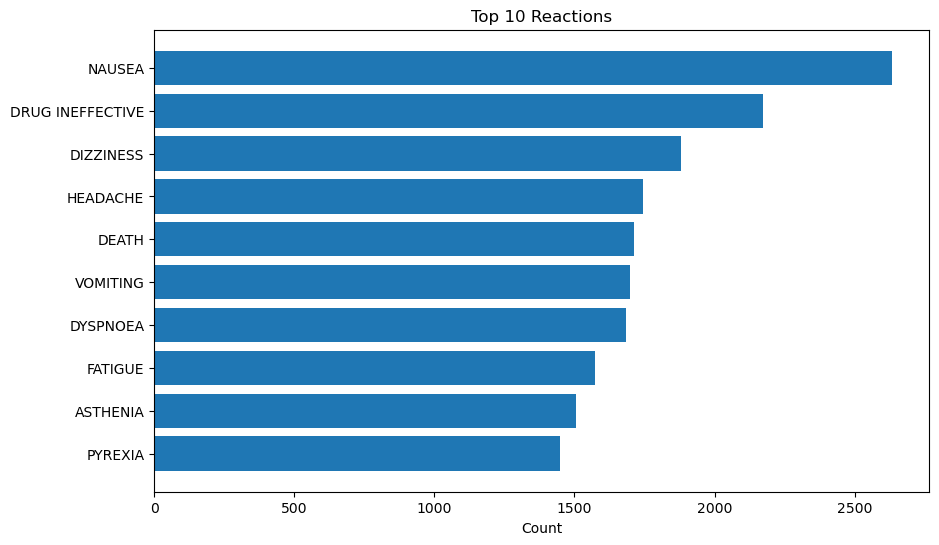

In [50]:
import matplotlib.pyplot as plt

pipeline = [
    {"$unwind": "$patient.reaction"},
    {"$group": {"_id": "$patient.reaction.reactionmeddrapt", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
]

results = list(db.reports.aggregate(pipeline))
labels = [res["_id"] for res in results]
counts = [res["count"] for res in results]

plt.figure(figsize=(10, 6))
plt.barh(labels, counts)
plt.xlabel("Count")
plt.title("Top 10 Reactions")
plt.gca().invert_yaxis()
plt.show()


In [51]:
# b. Time series of reports:

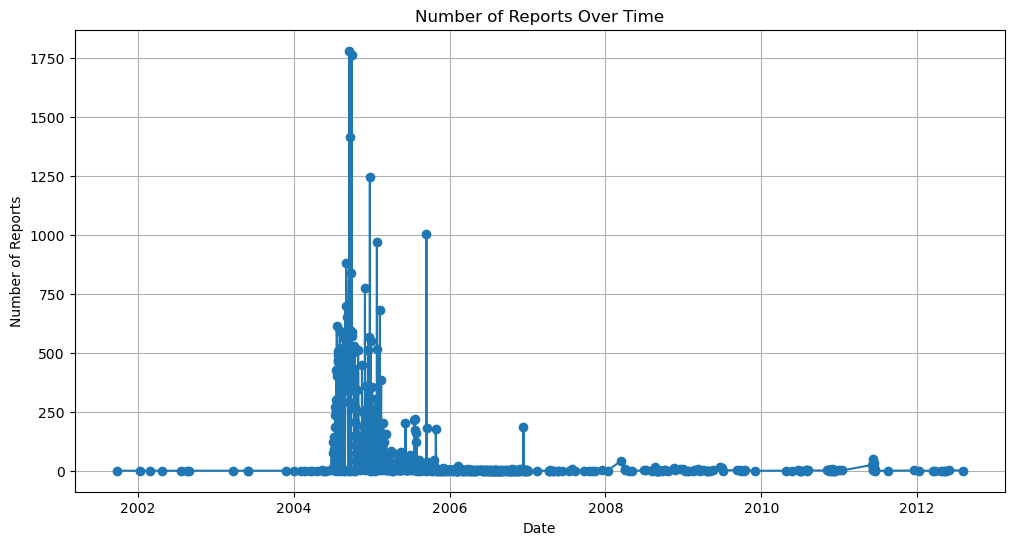

In [52]:
import pandas as pd

pipeline = [
    {"$group": {"_id": "$receivedate", "count": {"$sum": 1}}},
    {"$sort": {"_id": 1}}
]

results = list(db.reports.aggregate(pipeline))
df = pd.DataFrame(results)
df["_id"] = pd.to_datetime(df["_id"], format='%Y%m%d')
df = df.sort_values("_id")

plt.figure(figsize=(12, 6))
plt.plot(df["_id"], df["count"], marker="o")
plt.xlabel("Date")
plt.ylabel("Number of Reports")
plt.title("Number of Reports Over Time")
plt.grid()
plt.show()


In [53]:
#DO NOT RUN BELOW QUERIES UNTIL FURTHER PIPELINE DESIGN OPTIMIZATIONS

In [54]:
# 5. Cleanup and Maintenance
# a. Remove duplicate records:

In [55]:
# db.reports.aggregate([
#     {"$group": {"_id": "$safetyreportid", "dups": {"$push": "$_id"}, "count": {"$sum": 1}}},
#     {"$match": {"count": {"$gt": 1}}}
# ])

# # Remove duplicates:
# db.reports.delete_many({"_id": {"$in": dups}})


In [56]:
# b. Index fields for faster queries (e.g., receivedate, serious):


In [57]:
# db.reports.create_index("receivedate")
# db.reports.create_index("serious")


In [83]:
# %pip install pyspark


In [85]:
# %pip install "pymongo[srv]"


In [87]:
# conda install -c conda-forge openjdk=11


In [89]:
# brew install openjdk@11


In [66]:
#See Dec7ProjectTrial1

In [91]:
#cleanup data after experiment
from pymongo import MongoClient

# MongoDB connection setup
MONGO_URI = "mongodb://localhost:27017"  # Replace with your MongoDB URI
DB_NAME = "drug_data"
COLLECTION_NAME = "reports"

def main():
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]
    collection = db[COLLECTION_NAME]

    confirmation = input(f"Are you sure you want to drop the collection '{COLLECTION_NAME}'? (yes/no): ")
    if confirmation.lower() == "yes":
        collection.drop()
        print(f"Collection '{COLLECTION_NAME}' has been dropped.")
    else:
        print("Operation cancelled.")

if __name__ == "__main__":
    main()


Are you sure you want to drop the collection 'reports'? (yes/no):  yes


Collection 'reports' has been dropped.
